In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau, Callback
from tensorflow.keras.mixed_precision import set_global_policy
import math

set_global_policy('mixed_float16')
data_dir = 'D:/Major Project/Dataset/Masked_Dataset'
image_paths = []
labels = []
classes = sorted(os.listdir(data_dir))

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {len(classes)}")

batch_size = 64
target_size = (224, 224)
num_classes = len(classes)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def generator_to_tfdata(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, 224, 224, 3], [None, num_classes])
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

train_dataset = generator_to_tfdata(train_generator)
val_dataset = generator_to_tfdata(val_generator)
test_dataset = generator_to_tfdata(test_generator)

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Total samples: 73000
Training samples: 58400
Validation samples: 7300
Test samples: 7300
Number of classes: 73
Found 58400 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Found 7300 validated image filenames belonging to 73 classes.
Steps per epoch: 912
Validation steps: 114


In [2]:
def build_model(num_classes):
    base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model(num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Initial Model (Base Layers Frozen):")
print(f"Total parameters: {model.count_params()}")
print(f"Trainable parameters: {sum([w.shape.num_elements() for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {model.count_params() - sum([w.shape.num_elements() for w in model.trainable_weights])}")

csv_logger_initial = CSVLogger('D:/Major Project/resnet/training_history_initial_resnet50.csv', separator=',', append=False)
early_stopping_initial = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
model_checkpoint_initial = ModelCheckpoint('D:/Major Project/resnet/best_initial_resnet50.keras', monitor='val_accuracy', mode='max', save_best_only=True)

# Train initial model
history_initial = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping_initial, model_checkpoint_initial, csv_logger_initial],
    verbose=1
)
model.save_weights('D:/Major Project/resnet/initial_weights_resnet50.keras')
print("Saved initial weights to 'initial_weights_resnet50.keras'")

Initial Model (Base Layers Frozen):
Total parameters: 23859401
Trainable parameters: 271689
Non-trainable parameters: 23587712
Epoch 1/50
912/912 [==============================] - 647s 698ms/step - loss: 0.8606 - accuracy: 0.7465 - val_loss: 0.4861 - val_accuracy: 0.8351
Epoch 2/50
912/912 [==============================] - 640s 703ms/step - loss: 0.4145 - accuracy: 0.8601 - val_loss: 0.3407 - val_accuracy: 0.8809
Epoch 3/50
912/912 [==============================] - 623s 683ms/step - loss: 0.3454 - accuracy: 0.8793 - val_loss: 0.3092 - val_accuracy: 0.8973
Epoch 4/50
912/912 [==============================] - 562s 617ms/step - loss: 0.3075 - accuracy: 0.8917 - val_loss: 0.3056 - val_accuracy: 0.8966
Epoch 5/50
912/912 [==============================] - 579s 636ms/step - loss: 0.2842 - accuracy: 0.8979 - val_loss: 0.2891 - val_accuracy: 0.8999
Epoch 6/50
912/912 [==============================] - 557s 611ms/step - loss: 0.2674 - accuracy: 0.9054 - val_loss: 0.2290 - val_accuracy: 0.91

In [4]:
# Fine-tuning
for layer in base_model.layers[-17:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Fine-Tuned Model (Last 17 Layers Unfrozen):")
print(f"Total parameters: {model.count_params()}")
print(f"Trainable parameters: {sum([w.shape.num_elements() for w in model.trainable_weights])}")
print(f"Non-trainable parameters: {model.count_params() - sum([w.shape.num_elements() for w in model.trainable_weights])}")

csv_logger_fine = CSVLogger('D:/Major Project/resnet/training_history_fine_resnet50.csv', separator=',', append=False)
early_stopping_fine = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
model_checkpoint_fine = ModelCheckpoint('D:/Major Project/resnet/best_fine_tuned_resnet50.keras', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping_fine, model_checkpoint_fine, csv_logger_fine, reduce_lr],
    verbose=1
)
model.save_weights('D:/Major Project/resnet/all_weights_resnet50.keras')
print("Saved fine-tuned weights to 'all_weights_resnet50.keras'")


Fine-Tuned Model (Last 17 Layers Unfrozen):
Total parameters: 23859401
Trainable parameters: 8152905
Non-trainable parameters: 15706496
Epoch 1/30
912/912 [==============================] - 586s 634ms/step - loss: 0.2412 - accuracy: 0.9168 - val_loss: 0.2046 - val_accuracy: 0.9280 - lr: 1.0000e-05
Epoch 2/30
912/912 [==============================] - 570s 626ms/step - loss: 0.1849 - accuracy: 0.9355 - val_loss: 0.1837 - val_accuracy: 0.9359 - lr: 1.0000e-05
Epoch 3/30
912/912 [==============================] - 568s 624ms/step - loss: 0.1624 - accuracy: 0.9427 - val_loss: 0.1622 - val_accuracy: 0.9436 - lr: 1.0000e-05
Epoch 4/30
912/912 [==============================] - 557s 611ms/step - loss: 0.1486 - accuracy: 0.9475 - val_loss: 0.1533 - val_accuracy: 0.9456 - lr: 1.0000e-05
Epoch 5/30
912/912 [==============================] - 562s 616ms/step - loss: 0.1390 - accuracy: 0.9505 - val_loss: 0.1445 - val_accuracy: 0.9505 - lr: 1.0000e-05
Epoch 6/30
912/912 [=============================

In [5]:
# Save the final model
model.save('D:/Major Project/resnet/final_model_resnet50.keras')
print("Saved final fine-tuned model to 'final_model_resnet50.keras'")

Saved final fine-tuned model to 'final_model_resnet50.keras'


In [6]:
# Evaluate model
test_steps = math.ceil(len(test_df) / batch_size)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

115/115 [==============================] - 19s 155ms/step - loss: 0.0716 - accuracy: 0.9760
Test Loss: 0.0716, Test Accuracy: 0.9760


115/115 [==============================] - 16s 139ms/step
Length of y_true: 7300
Length of y_pred_classes: 7300


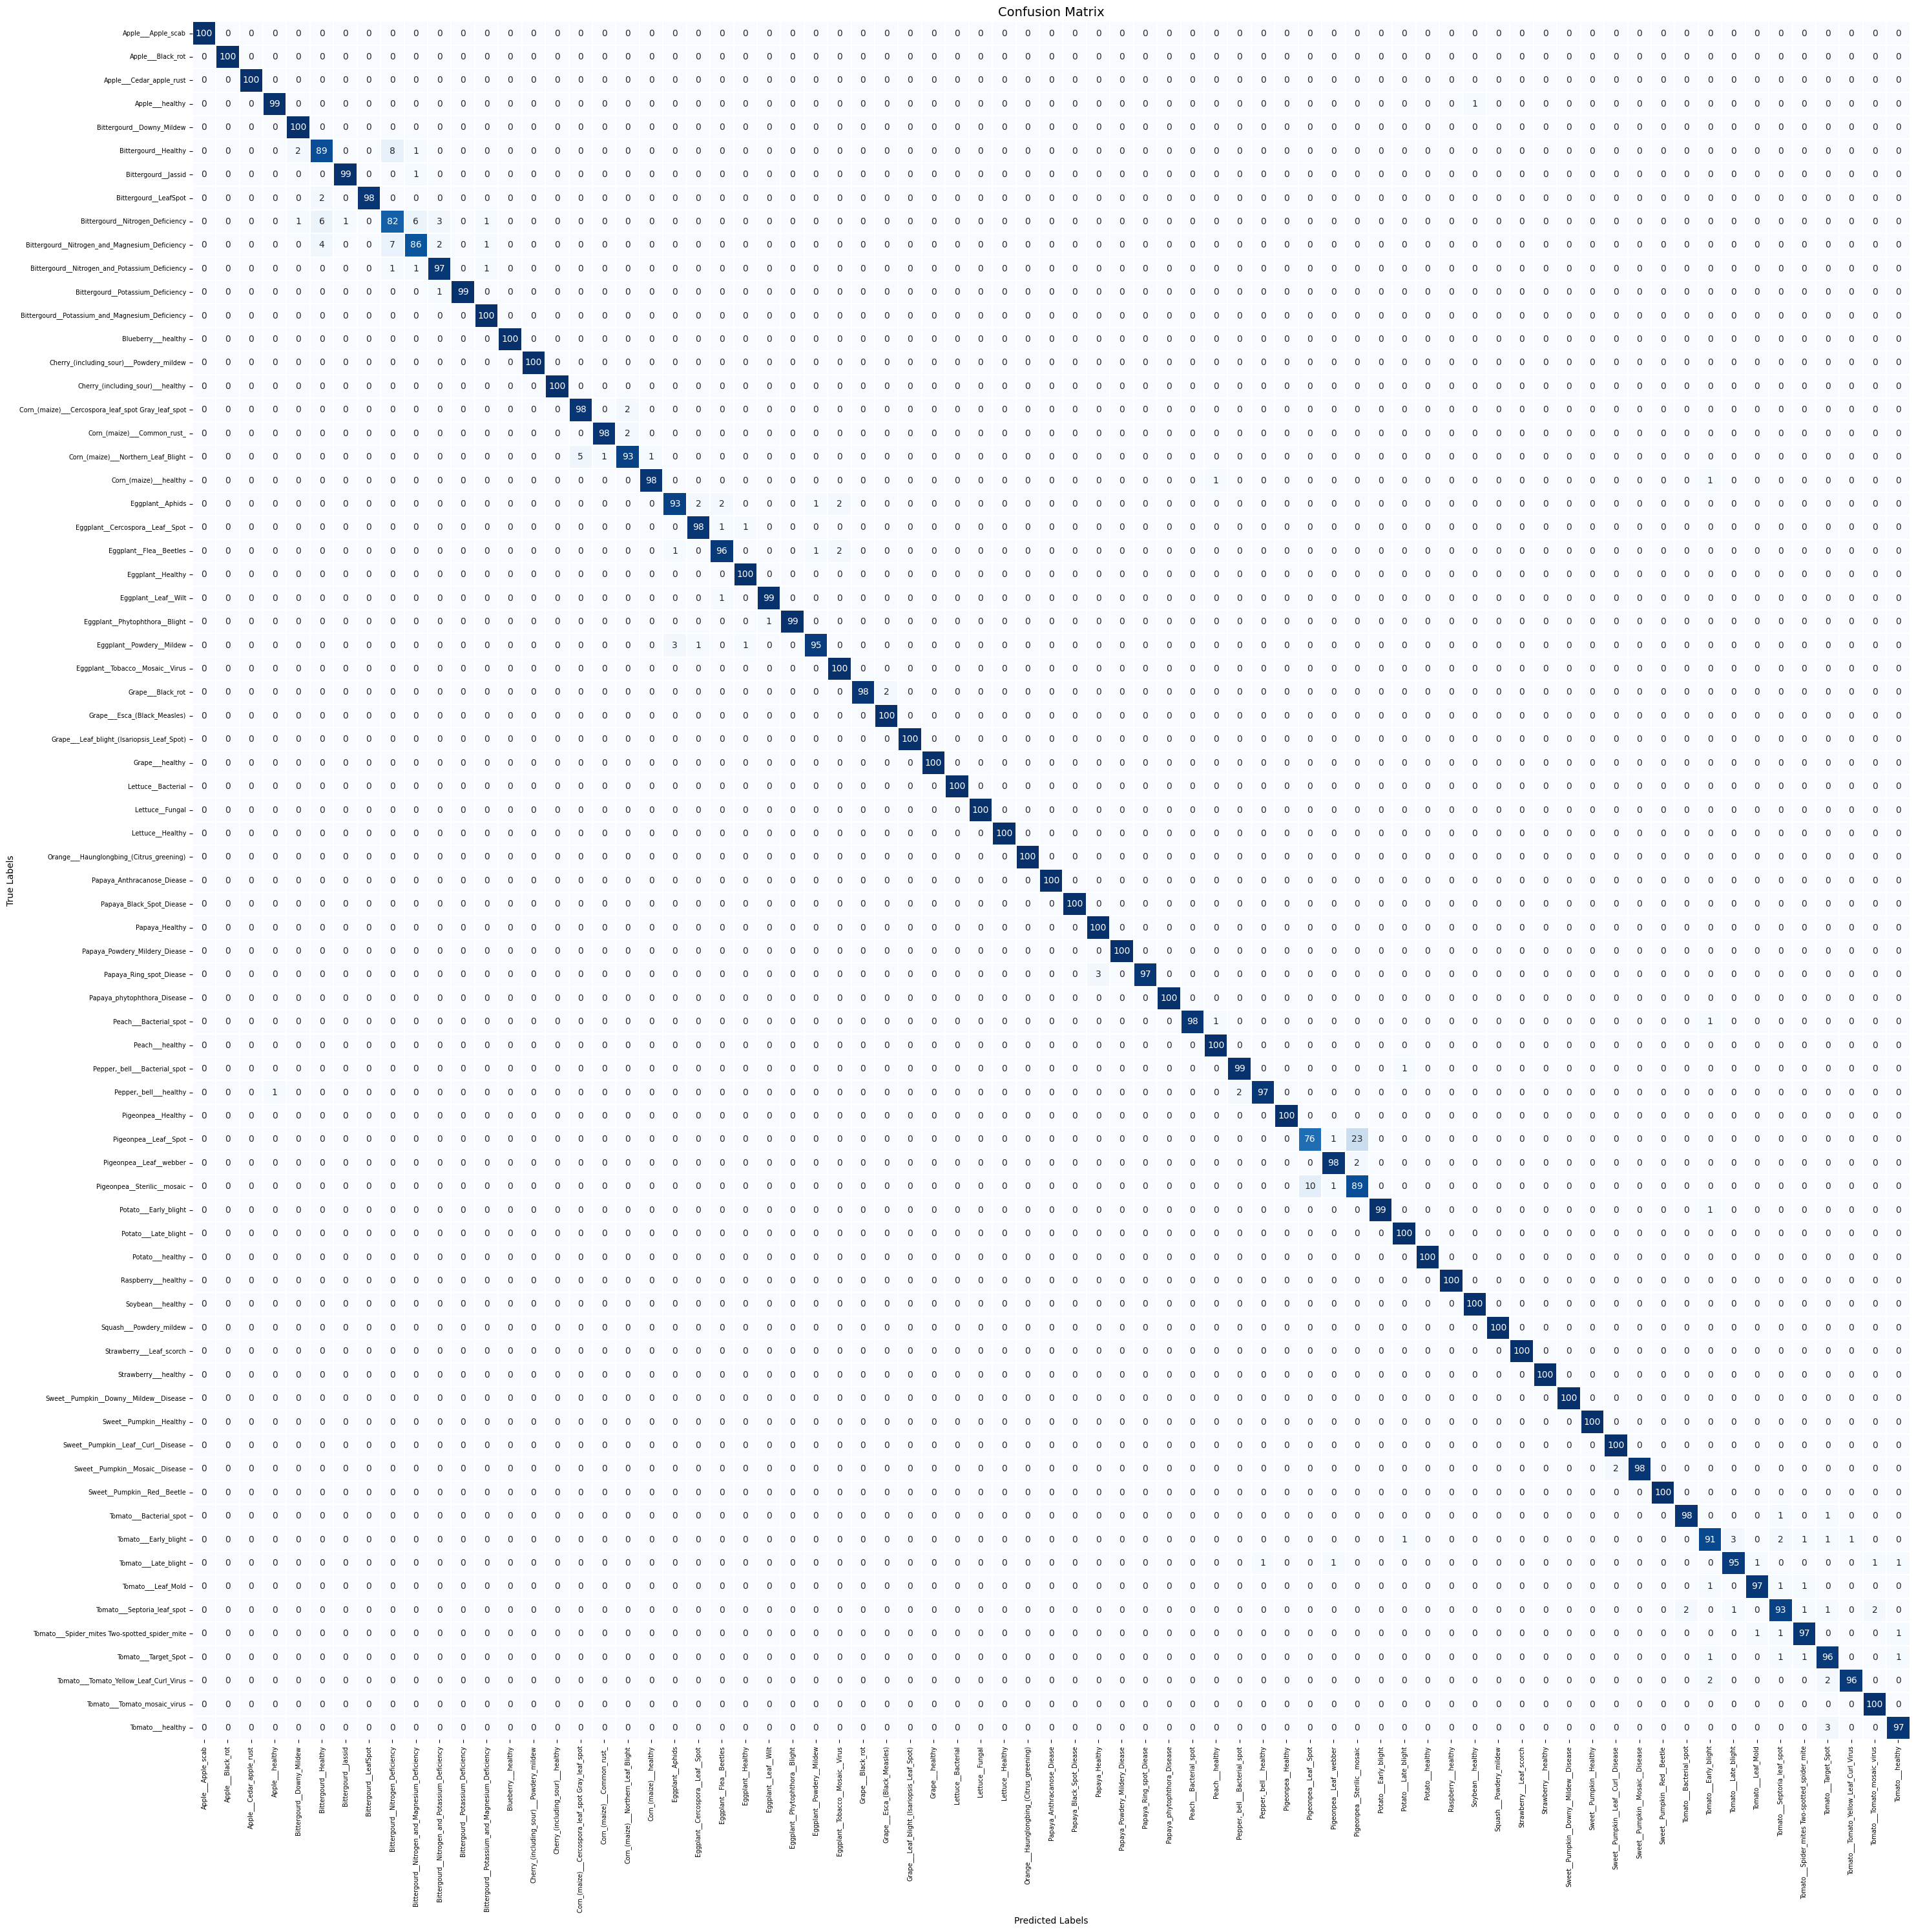

In [18]:
# Generate confusion matrix for all classes
import seaborn as sns
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_classes: {len(y_pred_classes)}")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(30, 30)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, linewidths=0.3, square=True)
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('D:/Major Project/resnet/confusion_matrix_resnet50.png')

115/115 [==============================] - 15s 123ms/step - loss: 0.0716 - accuracy: 0.9760
Test Loss: 0.0716, Test Accuracy: 0.9760
115/115 [==============================] - 14s 118ms/step


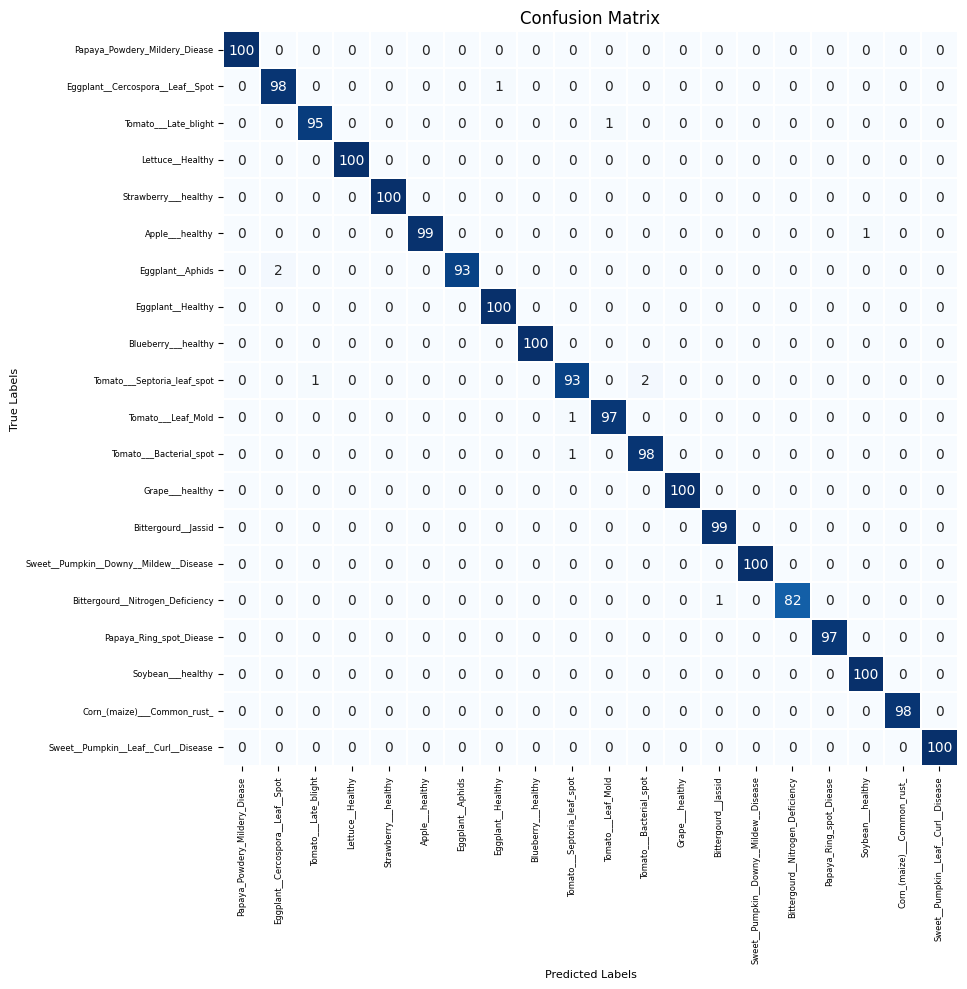

In [22]:
# Generate confusion matrix for random 20 labels
import random
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
if len(y_true) != len(y_pred_classes):
    print("Warning: Mismatch in lengths. Truncating y_true to match y_pred_classes.")
    y_true = y_true[:len(y_pred_classes)]
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

num_classes_to_show = 20
if len(class_labels) < num_classes_to_show:
    num_classes_to_show = len(class_labels)

random_classes = random.sample(class_labels, num_classes_to_show)
random_class_indices = [class_labels.index(cls) for cls in random_classes]
mask_true = np.isin(y_true, random_class_indices)

filtered_y_true_temp = y_true[mask_true]
filtered_y_pred_temp = y_pred_classes[mask_true]
mask_pred = np.isin(filtered_y_pred_temp, random_class_indices)

filtered_y_true = filtered_y_true_temp[mask_pred]
filtered_y_pred_classes = filtered_y_pred_temp[mask_pred]

label_mapping = {idx: i for i, idx in enumerate(random_class_indices)}
filtered_y_true_mapped = np.array([label_mapping[label] for label in filtered_y_true])
filtered_y_pred_mapped = np.array([label_mapping[label] for label in filtered_y_pred_classes])

cm = confusion_matrix(filtered_y_true_mapped, filtered_y_pred_mapped)

plt.figure(figsize=(10, 10)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=random_classes, yticklabels=random_classes,
            cbar=False, linewidths=0.3, square=True)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Predicted Labels', fontsize=8)
plt.ylabel('True Labels', fontsize=8)
plt.title('Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.savefig('D:/Major Project/resnet/confusion_matrix_resnet50_random_samples.png')

In [24]:
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('D:/Major Project/resnet/classification_report.csv')
print("Classification report saved to 'D:/Major Project/resnet/classification_report.csv'")
print("\nClassification Report:")
print(report_df)

predictions_df = pd.DataFrame({
    'True_Label': [class_labels[i] for i in y_true],
    'Predicted_Label': [class_labels[i] for i in y_pred_classes],
    'Confidence': np.max(y_pred, axis=1)
})
predictions_df.to_csv('D:/Major Project/resnet/test_predictions.csv', index=False)
print("Test predictions saved to 'D:/Major Project/resnet/test_predictions.csv'")

Classification report saved to 'D:/Major Project/resnet/classification_report.csv'

Classification Report:
                              precision    recall  f1-score      support
Apple___Apple_scab             1.000000  1.000000  1.000000   100.000000
Apple___Black_rot              1.000000  1.000000  1.000000   100.000000
Apple___Cedar_apple_rust       1.000000  1.000000  1.000000   100.000000
Apple___healthy                0.990000  0.990000  0.990000   100.000000
Bittergourd__Downy_Mildew      0.970874  1.000000  0.985222   100.000000
...                                 ...       ...       ...          ...
Tomato___Tomato_mosaic_virus   0.970874  1.000000  0.985222   100.000000
Tomato___healthy               0.970000  0.970000  0.970000   100.000000
accuracy                       0.976027  0.976027  0.976027     0.976027
macro avg                      0.976243  0.976027  0.975951  7300.000000
weighted avg                   0.976243  0.976027  0.975951  7300.000000

[76 rows x 4 col

In [26]:
# Training history for fine-tuned epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('D:/Major Project/resnet/training_history_fine.png')
plt.close()

Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'
Initial training epochs: 9
Fine-tuning epochs: 30
Total epochs: 39
Training history plot saved to 'D:/Major Project/resnet/training_history_combined.png'


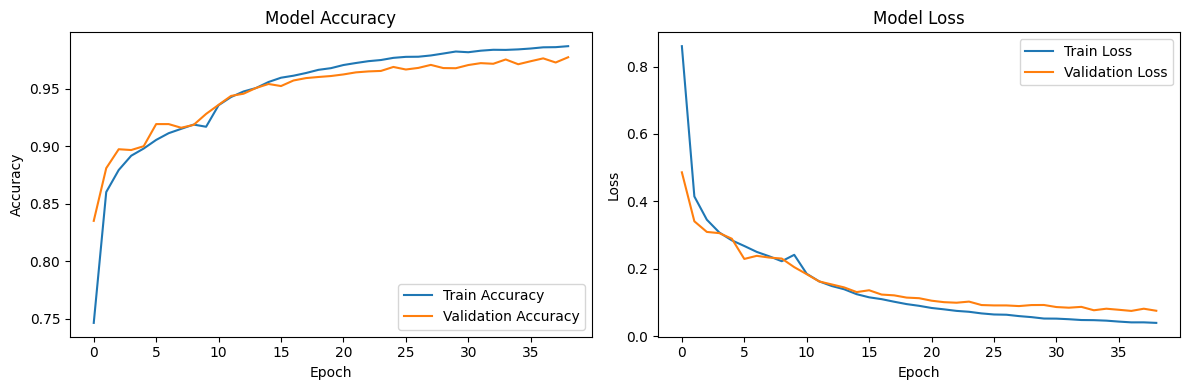

In [30]:
#Training history for both initial and fine-tuned epochs
try:
    history_initial_df = pd.read_csv('D:/Major Project/resnet/training_history_initial_resnet50.csv')
    history_fine_df = pd.read_csv('D:/Major Project/resnet/training_history_fine_resnet50.csv')
    print("Loaded training history from 'training_history_initial.csv' and 'training_history_fine.csv'")
except Exception as e:
    print(f"Error loading history CSVs: {e}")
    print("Please ensure 'training_history_initial.csv' and 'training_history_fine_initial.csv' exist in 'D:/Major Project/resnet/'")
    exit(1)

required_columns = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
if not all(col in history_initial_df.columns for col in required_columns) or \
   not all(col in history_fine_df.columns for col in required_columns):
    print("Error: CSV files must contain columns: 'accuracy', 'val_accuracy', 'loss', 'val_loss'")
    exit(1)

history_initial = {
    'accuracy': history_initial_df['accuracy'].tolist(),
    'val_accuracy': history_initial_df['val_accuracy'].tolist(),
    'loss': history_initial_df['loss'].tolist(),
    'val_loss': history_initial_df['val_loss'].tolist()
}
history_fine = {
    'accuracy': history_fine_df['accuracy'].tolist(),
    'val_accuracy': history_fine_df['val_accuracy'].tolist(),
    'loss': history_fine_df['loss'].tolist(),
    'val_loss': history_fine_df['val_loss'].tolist()
}
print(f"Initial training epochs: {len(history_initial['accuracy'])}")
print(f"Fine-tuning epochs: {len(history_fine['accuracy'])}")
print(f"Total epochs: {len(history_initial['accuracy']) + len(history_fine['accuracy'])}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_initial['accuracy'] + history_fine['accuracy'], label='Train Accuracy')
plt.plot(history_initial['val_accuracy'] + history_fine['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_initial['loss'] + history_fine['loss'], label='Train Loss')
plt.plot(history_initial['val_loss'] + history_fine['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('D:/Major Project/resnet/training_history_combined.png')
print("Training history plot saved to 'D:/Major Project/resnet/training_history_combined.png'")

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model_path = 'D:/Major Project/resnet/final_model_resnet50.keras'
try:
    model = tf.keras.models.load_model(model_path)
    print(f"Loaded Keras model from '{model_path}'")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Falling back to rebuilding model and loading weights")
    def build_model(num_classes):
        base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        for layer in base_model.layers:
            layer.trainable = False
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        predictions = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
        return model, base_model
    try:
        num_classes = len(test_generator.class_indices)
    except NameError:
        print("Error: test_generator not defined. Please define num_classes or test_generator.")
        sys.exit(1)
    model, base_model = build_model(num_classes)
    for layer in base_model.layers[-17:]:
        layer.trainable = True
    try:
        model.load_weights('D:/Major Project/resnet/all_weights_resnet50.keras')
        print("Loaded weights from 'all_weights_resnet50.keras'")
    except Exception as e:
        print(f"Error loading weights: {e}")
        sys.exit(1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False  
try:
    tflite_model = converter.convert()
except Exception as e:
    print(f"Error during float16 conversion: {e}")
    print("Falling back to float32 conversion without quantization")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()
    
tflite_path = 'D:/Major Project/resnet/resnet_model_float16.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Saved TFLite model to '{tflite_path}'")
print(f"TFLite model size: {os.path.getsize(tflite_path) / (1024 * 1024):.2f} MB")

Loaded Keras model from 'D:/Major Project/resnet/final_model_resnet50.keras'


INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpj1jdlkmj\assets


INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpj1jdlkmj\assets


Saved TFLite model to 'D:/Major Project/resnet/resnet_model_float16.tflite'
TFLite model size: 45.62 MB


In [40]:
# Convert to TFLite with int8 quantization
def representative_dataset():
    try:
        for i in range(100):
            img_path = test_df['image_path'].iloc[i]
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
            yield [img_array]
    except NameError:
        print("Error: test_df not defined. Please define test_df for int8 quantization.")
        return

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_lower_tensor_list_ops = False
try:
    tflite_int8_model = converter.convert()
    tflite_int8_path = 'D:/Major Project/resnet/resnet_model_int8.tflite'
    with open(tflite_int8_path, 'wb') as f:
        f.write(tflite_int8_model)
    print(f"Saved TFLite int8 model to '{tflite_int8_path}'")
    print(f"TFLite int8 model size: {os.path.getsize(tflite_int8_path) / (1024 * 1024):.2f} MB")
except Exception as e:
    print(f"Error during int8 conversion: {e}")
    print("Int8 conversion skipped. Use float16 model or update TensorFlow.")

INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpcru41ynj\assets


INFO:tensorflow:Assets written to: C:\Users\subbh\AppData\Local\Temp\tmpcru41ynj\assets
D:\Anaconda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved TFLite int8 model to 'D:/Major Project/resnet/resnet_model_int8.tflite'
TFLite int8 model size: 23.22 MB


In [44]:
try:
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    sample_img_path = test_df['image_path'].iloc[0]
    sample_label = test_df['label'].iloc[0]
    img = load_img(sample_img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    tflite_output = interpreter.get_tensor(output_details[0]['index'])
    tflite_pred_class = np.argmax(tflite_output, axis=1)[0]
    class_labels = list(test_generator.class_indices.keys())
    tflite_pred_label = class_labels[tflite_pred_class]
    tflite_confidence = np.max(tflite_output)

    keras_output = model.predict(img_array)
    keras_pred_class = np.argmax(keras_output, axis=1)[0]
    keras_pred_label = class_labels[keras_pred_class]
    keras_confidence = np.max(keras_output)

    print("\nTFLite Model Test Result:")
    print(f"Image: {sample_img_path}")
    print(f"True Label: {sample_label}")
    print(f"TFLite Predicted Label: {tflite_pred_label} (Confidence: {tflite_confidence:.4f})")
    print(f"Keras Predicted Label: {keras_pred_label} (Confidence: {keras_confidence:.4f})")
    print(f"Prediction Match: {tflite_pred_label == keras_pred_label}")

    print("\nClass Labels for Mobile App:")
    print(class_labels)
except NameError:
    print("Error: test_df or test_generator not defined. Skipping TFLite model testing.")
    print("Please define test_df and test_generator to test the TFLite model.")
except Exception as e:
    print(f"Error testing TFLite model: {e}")
    print("TFLite model generated but not tested. Please define test_df and test_generator to verify.")

1/1 [==============================] - 2s 2s/step

TFLite Model Test Result:
Image: D:/Major Project/Dataset/Masked_Dataset\Papaya_Ring_spot_Diease\aug_50030458246a4c23ba380a413729b6a7.jpg
True Label: Papaya_Ring_spot_Diease
TFLite Predicted Label: Papaya_Ring_spot_Diease (Confidence: 1.0000)
Keras Predicted Label: Papaya_Ring_spot_Diease (Confidence: 1.0000)
Prediction Match: True

Class Labels for Mobile App:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Bittergourd__Downy_Mildew', 'Bittergourd__Healthy', 'Bittergourd__Jassid', 'Bittergourd__LeafSpot', 'Bittergourd__Nitrogen_Deficiency', 'Bittergourd__Nitrogen_and_Magnesium_Deficiency', 'Bittergourd__Nitrogen_and_Potassium_Deficiency', 'Bittergourd__Potassium_Deficiency', 'Bittergourd__Potassium_and_Magnesium_Deficiency', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maiz

In [4]:
# Testing on user-input
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

tflite_model_path = 'D:/Major Project/resnet/resnet_model_float16.tflite'
keras_model_path = 'D:/Major Project/resnet/final_model_resnet50.keras'
image_path = 'D:/Major Project/Strawberry Scorch.png' 
true_label = 'Strawberry_Leaf_scorch'  
num_transformations = 5 

if not os.path.exists(tflite_model_path):
    print(f"Error: TFLite model not found at '{tflite_model_path}'")
    exit(1)
if not os.path.exists(keras_model_path):
    print(f"Error: Keras model not found at '{keras_model_path}'")
    exit(1)
if not os.path.exists(image_path):
    print(f"Error: Image not found at '{image_path}'")
    exit(1)

try:
    keras_model = tf.keras.models.load_model(keras_model_path)
    print(f"Loaded Keras model from '{keras_model_path}'")
except Exception as e:
    print(f"Error loading Keras model: {e}")
    exit(1)

try:
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print(f"Loaded TFLite model from '{tflite_model_path}'")
except Exception as e:
    print(f"Error loading TFLite model: {e}")
    exit(1)

is_int8 = input_details[0]['dtype'] == np.int8
print(f"TFLite model input type: {'int8' if is_int8 else 'float32'}")

test_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

try:
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    print(f"Original image loaded: shape={img_array.shape}")
except Exception as e:
    print(f"Error loading image: {e}")
    exit(1)

transformed_images = []
try:
    for i, batch in enumerate(test_datagen.flow(img_array, batch_size=1)):
        transformed_images.append(batch[0])  
        if i + 1 >= num_transformations:
            break
    transformed_images = np.array(transformed_images)  
    print(f"Generated {num_transformations} transformed images: shape={transformed_images.shape}")
except Exception as e:
    print(f"Error generating transformed images: {e}")
    exit(1)

all_images = np.concatenate([np.expand_dims(img_array[0], axis=0), transformed_images], axis=0)
print(f"Total images (original + transformed): {all_images.shape[0]}")

preprocessed_images = []
for img in all_images:
    img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img.copy())
    if is_int8:
        img_preprocessed = (img_preprocessed / 127.5 - 1.0) * 128
        img_preprocessed = np.clip(img_preprocessed, -128, 127).astype(np.int8)
    else:
        img_preprocessed = img_preprocessed.astype(np.float32)
    preprocessed_images.append(img_preprocessed)
preprocessed_images = np.array(preprocessed_images)  # Shape: (num_transformations + 1, 224, 224, 3)
print(f"Preprocessed images: shape={preprocessed_images.shape}, dtype={preprocessed_images.dtype}")

try:
    class_labels = list(test_generator.class_indices.keys())
    print("Class labels loaded from test_generator.class_indices")
except NameError:
    class_labels = ['Apple__Apple_scab', 'Apple_Black_rot', 'Apple_Cedar_apple_rust', 'Apple_healthy', 'BittergourdDowny_Mildew', 'BittergourdHealthy', 'BittergourdJassid', 
    'BittergourdLeafSpot', 'BittergourdNitrogen_Deficiency', 'BittergourdNitrogen_and_Magnesium_Deficiency', 'BittergourdNitrogen_and_Potassium_Deficiency', 'BittergourdPotassium_Deficiency', 
     'BittergourdPotassium_and_Magnesium_Deficiency', 'Blueberry_healthy', 'Cherry(including_sour)__Powdery_mildew', 'Cherry(including_sour)__healthy', 
     'Corn(maize)__Cercospora_leaf_spot Gray_leaf_spot', 'Corn(maize)__Common_rust', 'Corn_(maize)__Northern_Leaf_Blight', 'Corn(maize)__healthy', 'EggplantAphids', 
     'EggplantCercosporaLeafSpot', 'EggplantFleaBeetles', 'EggplantHealthy', 'EggplantLeafWilt', 'EggplantPhytophthoraBlight', 'EggplantPowderyMildew', 'EggplantTobaccoMosaicVirus',
     'Grape_Black_rot', 'Grape_Esca(Black_Measles)', 'Grape__Leaf_blight(Isariopsis_Leaf_Spot)', 'Grape__healthy', 'LettuceBacterial', 'LettuceFungal', 'LettuceHealthy', 
     'Orange_Haunglongbing(Citrus_greening)', 'Papaya_Anthracanose_Diease', 'Papaya_Black_Spot_Diease', 'Papaya_Healthy', 'Papaya_Powdery_Mildery_Diease', 'Papaya_Ring_spot_Diease',
     'Papaya_phytophthora_Disease', 'Peach__Bacterial_spot', 'Peach_healthy', 'Pepper,_bell_Bacterial_spot', 'Pepper,_bell_healthy', 'PigeonpeaHealthy', 'PigeonpeaLeafSpot', 
     'PigeonpeaLeafwebber', 'PigeonpeaSterilicmosaic', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Raspberry_healthy', 'Soybean_healthy', 'Squash_Powdery_mildew',
     'Strawberry_Leaf_scorch', 'Strawberry_healthy', 'SweetPumpkinDownyMildewDisease', 'SweetPumpkinHealthy', 'SweetPumpkinLeafCurlDisease', 'SweetPumpkinMosaicDisease', 
     'SweetPumpkinRedBeetle', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
     'Tomato_Spider_mites Two-spotted_spider_mite', 'Tomato_Target_Spot', 'Tomato_Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_Tomato_mosaic_virus', 'Tomato__healthy']
    print("Warning: test_generator not defined. Using manual class labels:")
    print(class_labels)

tflite_predictions = []
tflite_confidences = []
try:
    for i, img in enumerate(preprocessed_images):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(output, axis=1)[0]
        confidence = np.max(output)
        tflite_predictions.append(pred_class)
        tflite_confidences.append(confidence)
    print("TFLite inference completed")
except Exception as e:
    print(f"Error during TFLite inference: {e}")
    exit(1)

keras_predictions = []
keras_confidences = []
try:
    for img in preprocessed_images:
        keras_input = img.astype(np.float32) if is_int8 else img
        output = keras_model.predict(np.expand_dims(keras_input, axis=0))
        pred_class = np.argmax(output, axis=1)[0]
        confidence = np.max(output)
        keras_predictions.append(pred_class)
        keras_confidences.append(confidence)
    print("Keras inference completed")
except Exception as e:
    print(f"Error during Keras inference: {e}")
    exit(1)

print("\nTest Results:")
print(f"Image: {image_path}")
if true_label:
    print(f"True Label: {true_label}")
print("\nPredictions for Original and Transformed Images:")
for i, (tflite_pred, tflite_conf, keras_pred, keras_conf) in enumerate(zip(tflite_predictions, tflite_confidences, keras_predictions, keras_confidences)):
    image_type = "Original" if i == 0 else f"Transformed {i}"
    tflite_label = class_labels[tflite_pred]
    keras_label = class_labels[keras_pred]
    print(f"\n{image_type} Image:")
    print(f"  TFLite Predicted Label: {tflite_label} (Confidence: {tflite_conf:.4f})")
    print(f"  Keras Predicted Label: {keras_label} (Confidence: {keras_conf:.4f})")
    print(f"  Prediction Match: {tflite_label == keras_label}")
    if true_label:
        print(f"  TFLite Correct: {tflite_label == true_label}")
        print(f"  Keras Correct: {keras_label == true_label}")

tflite_majority = max(set(tflite_predictions), key=tflite_predictions.count)
keras_majority = max(set(keras_predictions), key=keras_predictions.count)
tflite_majority_label = class_labels[tflite_majority]
keras_majority_label = class_labels[keras_majority]
tflite_avg_conf = np.mean([tflite_confidences[i] for i in range(len(tflite_predictions)) if tflite_predictions[i] == tflite_majority])
keras_avg_conf = np.mean([keras_confidences[i] for i in range(len(keras_predictions)) if keras_predictions[i] == keras_majority])

print("\nSummary:")
print(f"TFLite Majority Prediction: {tflite_majority_label} (Average Confidence: {tflite_avg_conf:.4f})")
print(f"Keras Majority Prediction: {keras_majority_label} (Average Confidence: {keras_avg_conf:.4f})")
print(f"Majority Prediction Match: {tflite_majority_label == keras_majority_label}")
if true_label:
    print(f"TFLite Majority Correct: {tflite_majority_label == true_label}")
    print(f"Keras Majority Correct: {keras_majority_label == true_label}")
print(f"TFLite Prediction Consistency: {tflite_predictions.count(tflite_majority)}/{len(tflite_predictions)}")
print(f"Keras Prediction Consistency: {keras_predictions.count(keras_majority)}/{len(keras_predictions)}")

Loaded Keras model from 'D:/Major Project/resnet/final_model_resnet50.keras'
Loaded TFLite model from 'D:/Major Project/resnet/resnet_model_float16.tflite'
TFLite model input type: float32
Original image loaded: shape=(1, 224, 224, 3)
Generated 5 transformed images: shape=(5, 224, 224, 3)
Total images (original + transformed): 6
Preprocessed images: shape=(6, 224, 224, 3), dtype=float32
['Apple__Apple_scab', 'Apple_Black_rot', 'Apple_Cedar_apple_rust', 'Apple_healthy', 'BittergourdDowny_Mildew', 'BittergourdHealthy', 'BittergourdJassid', 'BittergourdLeafSpot', 'BittergourdNitrogen_Deficiency', 'BittergourdNitrogen_and_Magnesium_Deficiency', 'BittergourdNitrogen_and_Potassium_Deficiency', 'BittergourdPotassium_Deficiency', 'BittergourdPotassium_and_Magnesium_Deficiency', 'Blueberry_healthy', 'Cherry(including_sour)__Powdery_mildew', 'Cherry(including_sour)__healthy', 'Corn(maize)__Cercospora_leaf_spot Gray_leaf_spot', 'Corn(maize)__Common_rust', 'Corn_(maize)__Northern_Leaf_Blight', 'Co